In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils import data
import torchvision
from torchvision import transforms
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [3]:
batch_size = 256
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root=r"C:\Users\Lenovo\Desktop\visiondata", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root=r"C:\Users\Lenovo\Desktop\visiondata", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=12),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=12))
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

In [4]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y

    return (cmp.type(y.dtype).sum())
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def show_images(imgs, num_rows, num_cols, titles=None, scale=1):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            #print(img.squeeze().numpy())
            ax.imshow(img.squeeze().numpy())
        else:
            # PIL图片
            ax.imshow(img)
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
        #ax.axis('off')
    return axes

training on cuda:0
train_acc:0.1013,test_acc:0.1
train_acc:0.21393333333333334,test_acc:0.5165
train_acc:0.6015333333333334,test_acc:0.6054
train_acc:0.7028166666666666,test_acc:0.7072
train_acc:0.7388833333333333,test_acc:0.6994
train_acc:0.7621166666666667,test_acc:0.7602
train_acc:0.7806666666666666,test_acc:0.7688
train_acc:0.7968666666666666,test_acc:0.7982
train_acc:0.8117666666666666,test_acc:0.7833
train_acc:0.8214333333333333,test_acc:0.8222
loss 0.475, train acc 0.821, test acc 0.822
2093.36754386423 examples/sec on cuda:0


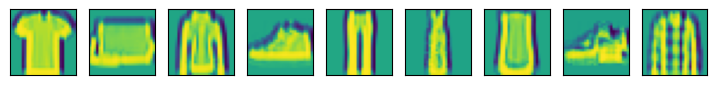

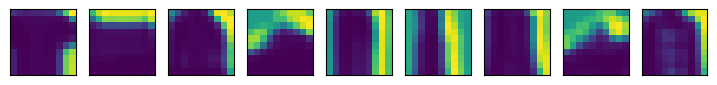

In [5]:
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
#@save
import time
def train_ch6_3(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    timer, num_batches = time.time(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        print(rf"train_acc:{train_acc},test_acc:{test_acc}")
    x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :]
    show_images(x_first_Sigmoid_layer.reshape(9, 28, 28).cpu().detach(), 1, 9)
    x_second_Sigmoid_layer = net[0:5](X)[0:9, 1, :, :]
    show_images(x_second_Sigmoid_layer.reshape(9, 10, 10).cpu().detach(), 1, 9)
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / (time.time()-timer)} examples/sec '
          f'on {str(device)}')
lr, num_epochs = 0.9, 10
train_ch6_3(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [9]:
lr, num_epochs = 0.9, 10
#train_ch6(net, train_iter, test_iter, num_epochs, lr,try_gpu())
train_ch6(net, train_iter, test_iter, num_epochs, lr,torch.device('cpu'))

training on cpu
epoch0: loss2.361312911865559,acc0.10330784574468085
epoch0: loss2.3375485831118645,acc0.10206117021276596
epoch0: loss2.329039544923931,acc0.10064827127659574
epoch0: loss2.323611130105688,acc0.10081449468085106
epoch0: loss2.3199821680704753,acc0.10208333333333333
epoch0: testacc0.1
epoch1: loss2.303870774329977,acc0.09674202127659574
epoch1: loss2.3004840967503,acc0.10679853723404255
epoch1: loss2.2697279385641114,acc0.1322307180851064
epoch1: loss2.0846475318391273,acc0.19971742021276595
epoch1: loss1.9177910769144695,acc0.25716666666666665
epoch1: testacc0.4818
epoch2: loss1.0853477919355352,acc0.562749335106383
epoch2: loss1.0310274165995577,acc0.5893035239361702
epoch2: loss1.0023803478437112,acc0.6015625
epoch2: loss0.9725602082115539,acc0.6136136968085106
epoch2: loss0.94049265721639,acc0.6276333333333334
epoch2: testacc0.6375
epoch3: loss0.8117330429401803,acc0.6802692819148937
epoch3: loss0.7751781566345946,acc0.6914893617021277
epoch3: loss0.7649399819948994

In [7]:
!nvidia-smi

Tue May 13 19:36:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.28                 Driver Version: 576.28         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   65C    P0             17W /   50W |    1156MiB /   4096MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
import torch
print(torch.__version__) # 查看torch版本
print(torch.cuda.is_available()) # 看安装好的torch和cuda能不能用，也就是看GPU能不能用

print(torch.version.cuda) # 输出一个 cuda 版本，注意：上述输出的 cuda 的版本并不一定是 Pytorch 在实际系统上运行时使用的 cuda 版本，而是编译该 Pytorch release 版本时使用的 cuda 版本，详见：https://blog.csdn.net/xiqi4145/article/details/110254093


2.6.0+cu124
True
12.4
